In [1]:
# %pip install scikit-learn xgboost catboost

In [2]:
import torch
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

True
True


In [3]:
import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV, cross_validate
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.svm import SVR

try:
    import xgboost as xgb
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("XGBoost not installed. Skipping XGBoost model.")

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except ImportError:
    HAS_CAT = False
    print("CatBoost not installed. Skipping CatBoost model.")

In [25]:
#Data Loading and Initial Cleaning

test_df = pd.read_csv('/Users/millicentomondi/Documents/DSN/hackathon-qualification (1)/data/test.csv')
df1 = pd.read_csv('/Users/millicentomondi/Documents/DSN/hackathon-qualification (1)/data/train.csv')
df2 = pd.read_csv('/Users/millicentomondi/Documents/DSN/hackathon-qualification (1)/data/used_cars.csv')


In [5]:
# Drop 'id' from training data
df1 = df1.drop('id', axis=1)

In [6]:
# Clean df2 price and milage columns
df2['price'] = df2['price'].astype(str).str.replace('$', '', regex=False).str.replace(',', '', regex=False).astype(int)
df2['milage'] = df2['milage'].astype(str).str.replace('mi.', '', regex=False).str.replace(',', '', regex=False).astype(int)

# Merge dataframes
df_merged = pd.concat([df1, df2])

print("Data loaded and merged successfully.")


Data loaded and merged successfully.


In [7]:
# Save the merged dataframe to a new CSV file
df_merged.to_csv('/Users/millicentomondi/Documents/DSN/merged_data.csv', index=False)
print("Merged dataframe saved to merged_data.csv")

Merged dataframe saved to merged_data.csv


In [8]:

def eda(df, name="DataFrame"):
    print(f"\n--- EDA for {name} ---")
    print("First 5 rows of the dataset:")
    print(df.head())

    print("\nDataset information:")
    df.info()

    print("\nDescriptive statistics for numerical columns:")
    print(df.describe().T)

    print("\nDescriptive statistics for categorical columns:")
    print(df.describe(include='object'))

    print("\nMissing values per column:")
    print(df.isnull().sum())

eda(df_merged, "Training Data")


--- EDA for Training Data ---
First 5 rows of the dataset:
           brand              model  model_year  milage      fuel_type  \
0           MINI      Cooper S Base        2007  213000       Gasoline   
1        Lincoln              LS V8        2002  143250       Gasoline   
2      Chevrolet  Silverado 2500 LT        2002  136731  E85 Flex Fuel   
3        Genesis   G90 5.0 Ultimate        2017   19500       Gasoline   
4  Mercedes-Benz        Metris Base        2021    7388       Gasoline   

                                              engine  \
0       172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel   
1       252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel   
2  320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...   
3       420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel   
4       208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel   

                     transmission ext_col int_col  \
0                             A/T  Yellow    Gray   
1                             A/T  Silver   Beige   

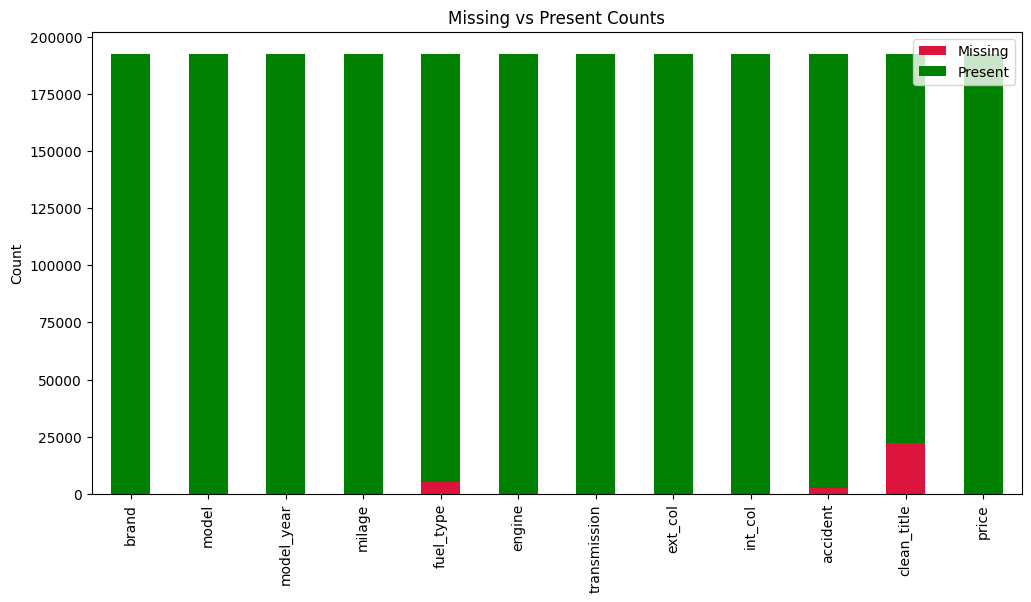

In [9]:
# Visualizing Missing values
missing_counts = df_merged.isnull().sum()
present_counts = df_merged.notnull().sum()

plot_df = pd.DataFrame({
    "Missing": missing_counts,
    "Present": present_counts
})

plot_df.plot(kind="bar", stacked=True,
             color=["crimson", "green"], figsize=(12,6))
plt.title("Missing vs Present Counts")
plt.ylabel("Count")
plt.show()

In [10]:
# Replace '-' with NaN (function definition)
def replace_dash_with_nan(df, col):
    df[col] = df[col].replace(["-", "–"], np.nan)
    return df

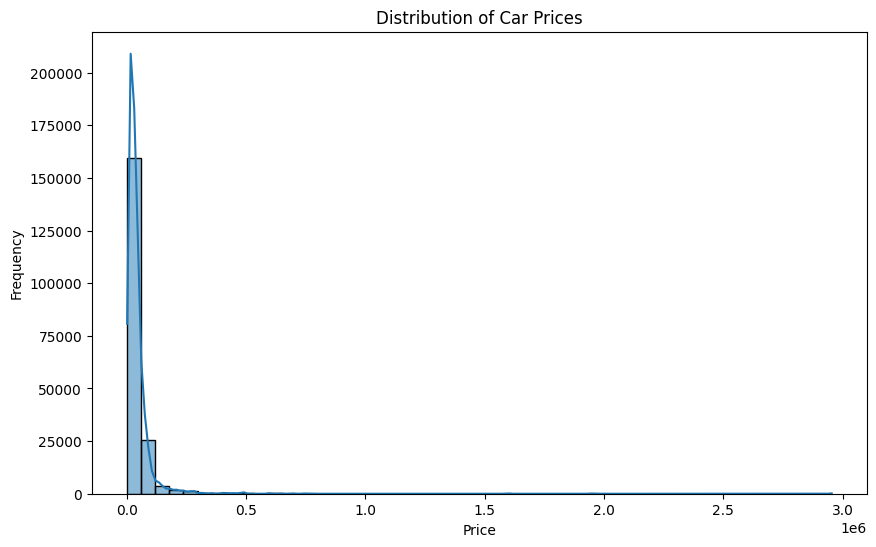

In [11]:
# Histogram of price distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_merged['price'], kde=True, bins=50)
plt.title('Distribution of Car Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

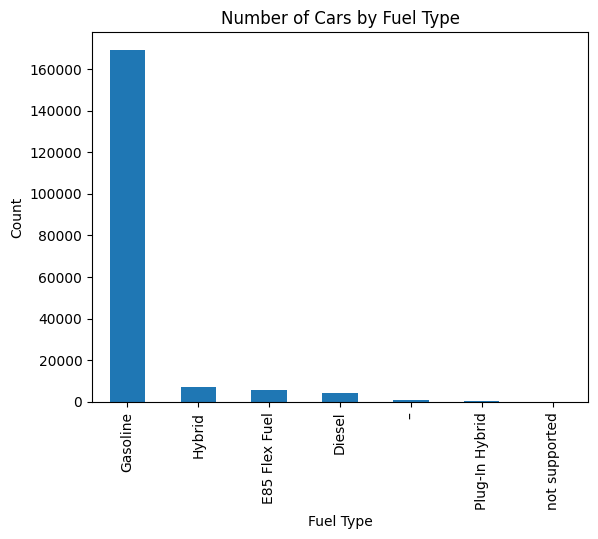

In [12]:
# Bar chart showing counts of cars by fuel type
plt.figure()
df_merged['fuel_type'].value_counts().plot(kind='bar')
plt.title('Number of Cars by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Count')
plt.show()

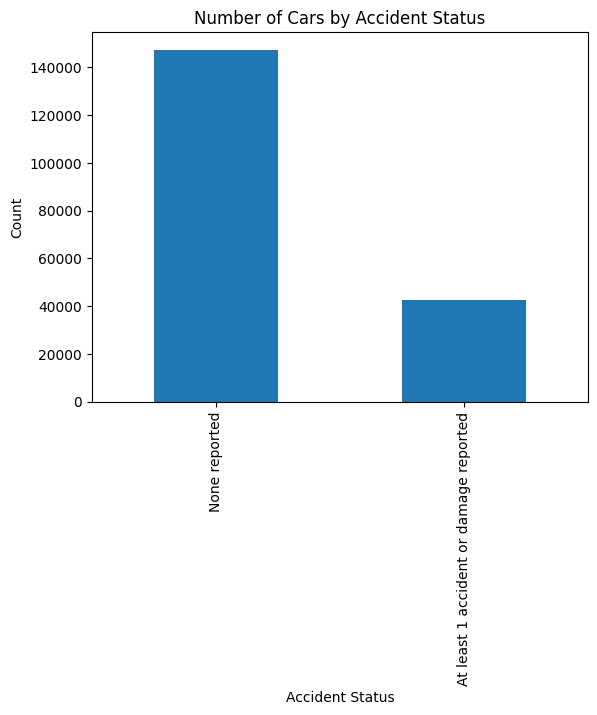

In [13]:
# Bar chart showing counts of cars by accident status
plt.figure()
df_merged['accident'].value_counts().plot(kind='bar')
plt.title('Number of Cars by Accident Status')
plt.xlabel('Accident Status')
plt.ylabel('Count')
plt.show()

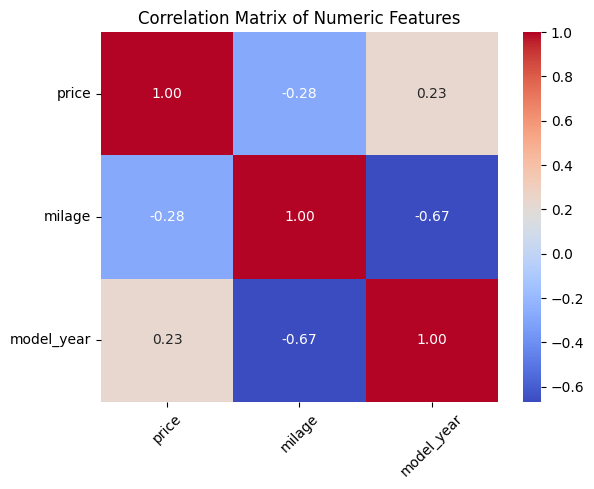

In [14]:
# Correlation heatmap for numeric features
numeric_cols = ['price', 'milage', 'model_year']
corr_matrix = df_merged[numeric_cols].corr()
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [26]:

# Identify target column
TARGET = "price"
RANDOM_STATE = 42

X = df_merged.drop(columns=[TARGET])
y = df_merged[TARGET].copy()

id_test = test_df["id"].copy()
X_test = test_df.drop(columns=["id"])

print("Data split into X, y, X_test, id_test.")




Data split into X, y, X_test, id_test.


In [16]:
# Preprocessor

def _replace_dashes_to_nan(df: pd.DataFrame, cols=None) -> pd.DataFrame:
    df = df.copy()
    if cols is None:
        cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    df[cols] = (
        df[cols]
        .apply(lambda s: s.astype(str).str.strip())
        .replace({"-": np.nan, "–": np.nan, "": np.nan})
    )
    return df

def _basic_cleaner(df: pd.DataFrame, dash_cols=None) -> pd.DataFrame:
    return _replace_dashes_to_nan(df, cols=dash_cols)

def make_preprocessor(df: pd.DataFrame, card_threshold: int = 20, dash_cols=None,
                      scale_numeric: bool = True):
    df_clean = _basic_cleaner(df, dash_cols=dash_cols)

    num_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df_clean.select_dtypes(include=['object', 'category']).columns.tolist()

    low_card_cats  = [c for c in cat_cols if df_clean[c].nunique(dropna=False) <= card_threshold]
    high_card_cats = [c for c in cat_cols if c not in low_card_cats]

    num_steps = [('imp', SimpleImputer(strategy='median'))]
    if scale_numeric:
        num_steps.append(('scaler', StandardScaler()))
    num_pre = Pipeline(steps=num_steps)

    ohe_pre = Pipeline(steps=[
        ('imp', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    ord_pre = Pipeline(steps=[
        ('imp', SimpleImputer(strategy='constant', fill_value='Unknown')),
        ('ord', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
    ])

    preproc = ColumnTransformer(
        transformers=[
            ('num', num_pre, num_cols),
            ('ohe', ohe_pre, low_card_cats),
            ('ord', ord_pre, high_card_cats),
        ],
        remainder='drop'
    )

    cleaner = FunctionTransformer(_basic_cleaner, kw_args={'dash_cols': dash_cols})
    feat_info = {'num_cols': num_cols, 'low_card_cats': low_card_cats, 'high_card_cats': high_card_cats}
    return cleaner, preproc, feat_info


# Build preprocessor
cleaner, preproc_default, feat_info = make_preprocessor(X, card_threshold=20, scale_numeric=True)
print("Preprocessor built.")

Preprocessor built.


In [17]:
# Scorer and Cross-Validation Setup

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse, greater_is_better=False)
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
print("RMSE scorer and KFold cross-validation setup.")


RMSE scorer and KFold cross-validation setup.


In [18]:
# Model Pipelines

pipelines = {}

pipelines['LinearRegression'] = Pipeline([
    ('clean', cleaner),
    ('prep', preproc_default),
    ('mdl', LinearRegression())
])

pipelines['RobustRegression'] = Pipeline([
    ('clean', cleaner),
    ('prep', preproc_default),
    ('mdl', HuberRegressor(epsilon=1.35, alpha=1e-4))
])

pipelines['GradientBoosting'] = Pipeline([
    ('clean', cleaner),
    ('prep', preproc_default),
    ('mdl', GradientBoostingRegressor(random_state=RANDOM_STATE))
])

pipelines['RandomForest'] = Pipeline([
    ('clean', cleaner),
    ('prep', preproc_default),
    ('mdl', RandomForestRegressor(
        n_estimators=400, n_jobs=-1, random_state=RANDOM_STATE
    ))
])

if HAS_XGB:
    pipelines['XGBoost'] = Pipeline([
        ('clean', cleaner),
        ('prep', preproc_default),
        ('mdl', XGBRegressor(
            n_estimators=600, max_depth=8, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8,
            tree_method='hist',
            random_state=RANDOM_STATE
        ))
    ])

if HAS_CAT:
    pipelines['CatBoost'] = Pipeline([
        ('clean', cleaner),
        ('prep', preproc_default),
        ('mdl', CatBoostRegressor(
            depth=8, learning_rate=0.05, n_estimators=800,
            loss_function='RMSE',
            task_type='CPU',
            random_state=RANDOM_STATE, verbose=0
        ))
    ])


print("All base model pipelines defined.")


All base model pipelines defined.


In [19]:
# Parameter Grids for GridSearchCV

param_grids = {
    'LinearRegression': {},  # has no tunable hyperparams via GridSearchCV

    'RobustRegression': {
        'mdl__epsilon': [1.35, 1.5],
        'mdl__alpha': [1e-4, 1e-3]
    },

    'GradientBoosting': {
        'mdl__n_estimators': [100, 200, 300, 500],
        'mdl__learning_rate': [0.01, 0.05, 0.1, 0.2],
        'mdl__max_depth': [3, 4, 5, 7],
        'mdl__subsample': [0.7, 0.8, 0.9, 1.0],
        'mdl__min_samples_leaf': [1, 5, 10, 20],
        'mdl__min_samples_split': [2, 5, 10, 20],
        'mdl__max_features': ['sqrt', 0.8, 1.0],
        'mdl__n_iter_no_change': [5, 10],
        'mdl__validation_fraction': [0.1, 0.2]
    },

    'RandomForest': {
        'mdl__n_estimators': [100, 200],
        'mdl__max_depth': [10, 20],

    },

}

if HAS_XGB:
    param_grids['XGBoost'] = {
        'mdl__n_estimators': [200, 400],
        'mdl__max_depth': [6, 8],
        'mdl__learning_rate': [0.05, 0.1],
        'mdl__early_stopping_rounds': [10, 20]
    }

if HAS_CAT:
    param_grids['CatBoost'] = {
        'mdl__n_estimators': [300, 600, 900, 1200],
        'mdl__depth': [6, 8, 10],
        'mdl__learning_rate': [0.01, 0.03, 0.05, 0.1],
        'mdl__l2_leaf_reg': [1, 3, 5, 7, 9],
        'mdl__early_stopping_rounds': [10, 20, 30]
    }

print("Parameter grids defined (reduced for faster execution).")


Parameter grids defined (reduced for faster execution).


In [20]:

# ------------------ Run GridSearchCV per model ------------------
tuned_pipelines = {}
print("\n=== Starting Grid Search (5-fold CV, RMSE) ===")
for name, pipe in pipelines.items():
    try:
        grid = param_grids.get(name, None)

        if grid is None or len(grid) == 0:
            print(f"[{name}] No hyperparameters to tune via GridSearchCV; using default pipeline.")
            tuned_pipelines[name] = pipe.fit(X, y)
            continue

        print(f"\n--- Running Hyperparameter Tuning for {name} ---")

        # RandomizedSearchCV ---
        if name == 'GradientBoosting' or name == 'RandomForest' or name == 'XGBoost' or name == 'CatBoost': # Apply to complex models
            # For RandomizedSearchCV
            search_estimator = RandomizedSearchCV(
                estimator=pipe,
                param_distributions=grid,
                n_iter=50,
                scoring=rmse_scorer,
                cv=cv,
                n_jobs=-1,
                refit=True,
                random_state=RANDOM_STATE,
                verbose=1,
                error_score='raise'
            )
        else: # GridSearchCV is for simpler models or smaller grids
            search_estimator = GridSearchCV(
                estimator=pipe,
                param_grid=grid,
                scoring=rmse_scorer,
                cv=cv,
                n_jobs=-1,
                refit=True,
                verbose=1
            )

        search_estimator.fit(X, y)

        best_rmse = -search_estimator.best_score_
        print(f"[{name}] Best CV RMSE: {best_rmse:,.2f}")
        print(f"[{name}] Best Params: {search_estimator.best_params_}")

        tuned_pipelines[name] = search_estimator.best_estimator_

    except Exception as e:
        print(f"[{name}] FAILED during hyperparameter search: {e}")
print("\n=== Hyperparameter Search Complete ===")



=== Starting Grid Search (5-fold CV, RMSE) ===
[LinearRegression] No hyperparameters to tune via GridSearchCV; using default pipeline.

--- Running Hyperparameter Tuning for RobustRegression ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in vers

[RobustRegression] Best CV RMSE: 75,818.09
[RobustRegression] Best Params: {'mdl__alpha': 0.0001, 'mdl__epsilon': 1.5}

--- Running Hyperparameter Tuning for GradientBoosting ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: '

[GradientBoosting] Best CV RMSE: 72,647.59
[GradientBoosting] Best Params: {'mdl__validation_fraction': 0.1, 'mdl__subsample': 1.0, 'mdl__n_iter_no_change': 10, 'mdl__n_estimators': 500, 'mdl__min_samples_split': 20, 'mdl__min_samples_leaf': 5, 'mdl__max_features': 'sqrt', 'mdl__max_depth': 5, 'mdl__learning_rate': 0.05}

--- Running Hyperparameter Tuning for RandomForest ---
Fitting 5 folds for each of 4 candidates, totalling 20 fits


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: '

[RandomForest] Best CV RMSE: 74,548.15
[RandomForest] Best Params: {'mdl__n_estimators': 200, 'mdl__max_depth': 10}

--- Running Hyperparameter Tuning for XGBoost ---
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[XGBoost] FAILED during hyperparameter search: Must have at least 1 validation dataset for early stopping.

--- Running Hyperparameter Tuning for CatBoost ---
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: '

[CatBoost] Best CV RMSE: 72,558.58
[CatBoost] Best Params: {'mdl__n_estimators': 600, 'mdl__learning_rate': 0.03, 'mdl__l2_leaf_reg': 5, 'mdl__early_stopping_rounds': 20, 'mdl__depth': 10}

=== Hyperparameter Search Complete ===


In [21]:
# ------------------ Cross-validate & Compare All Tuned Models ------------------

print("\n=== Starting Cross-validation and Comparison of Tuned Models ===")
rows = []
for name, pipe in tuned_pipelines.items(): # Iterate over tuned_pipelines for evaluation
    try:
        cv_res = cross_validate(pipe, X, y, scoring=rmse_scorer, cv=cv,
                                n_jobs=-1, return_train_score=False)
        mean_rmse = -np.mean(cv_res['test_score'])
        std_rmse  =  np.std(-cv_res['test_score'])
        rows.append((name, mean_rmse, std_rmse, np.mean(cv_res['fit_time'])))
        print(f"{name:18s} | CV RMSE: {mean_rmse:,.2f} ± {std_rmse:,.2f}")
    except Exception as e:
        print(f"{name:18s} | FAILED in evaluation: {e}")

results_df = pd.DataFrame(rows, columns=['Model', 'CV_RMSE', 'CV_RMSE_STD', 'FitTimeSec']).sort_values('CV_RMSE')
print("\nSorted CV results (lower is better):\n")
print(results_df.to_string(index=False))


=== Starting Cross-validation and Comparison of Tuned Models ===


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: '

LinearRegression   | CV RMSE: 74,632.77 ± 3,126.08


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (

RobustRegression   | CV RMSE: 75,818.09 ± 3,166.08


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: '

GradientBoosting   | CV RMSE: 72,647.59 ± 3,145.77


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: '

RandomForest       | CV RMSE: 74,548.15 ± 3,068.90


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: '

CatBoost           | CV RMSE: 72,558.58 ± 3,159.95

Sorted CV results (lower is better):

           Model      CV_RMSE  CV_RMSE_STD  FitTimeSec
        CatBoost 72558.583653  3159.945774   18.639585
GradientBoosting 72647.589545  3145.771458   12.787856
    RandomForest 74548.153525  3068.901088   43.747264
LinearRegression 74632.766800  3126.080220    0.639316
RobustRegression 75818.093546  3166.083315    2.574996


/Users/millicentomondi/anaconda3/envs/.env/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
# Fit Overall Best Model on Full Train

best_model_name = results_df.iloc[0]['Model']
best_pipeline = tuned_pipelines[best_model_name] # Use the tuned_pipelines for the best model

print(f"\nOverall Best Model by CV RMSE: {best_model_name}")


Overall Best Model by CV RMSE: CatBoost


In [28]:
# fit best pipeline on test set
best_pipeline.fit(X, y)
y_test_pred = best_pipeline.predict(X_test)

print("Overall best model fitted and predictions made on test set.")


Overall best model fitted and predictions made on test set.


In [29]:

#  Create Submission File

submission = pd.DataFrame({"id": id_test, "price": y_test_pred})
submission.to_csv("submission_best_model.csv", index=False) # Renamed for clarity
print("Saved: submission_best_model.csv")

Saved: submission_best_model.csv
